In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
from numpy import pi as pi

#set plotting parameters
pysh.utils.figstyle(rel_width=0.1)
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

We start by setting the truncation degree for the calculations

In [44]:
L=256

Next we read in the initial sea level, $SL$, and ice thickness, $I$, from a data file. These variables are stored on a real Gauss-Legendre grid. They can be plotted showing coastlines using SL.geo_plot() whose second argument selects the colourmap used.

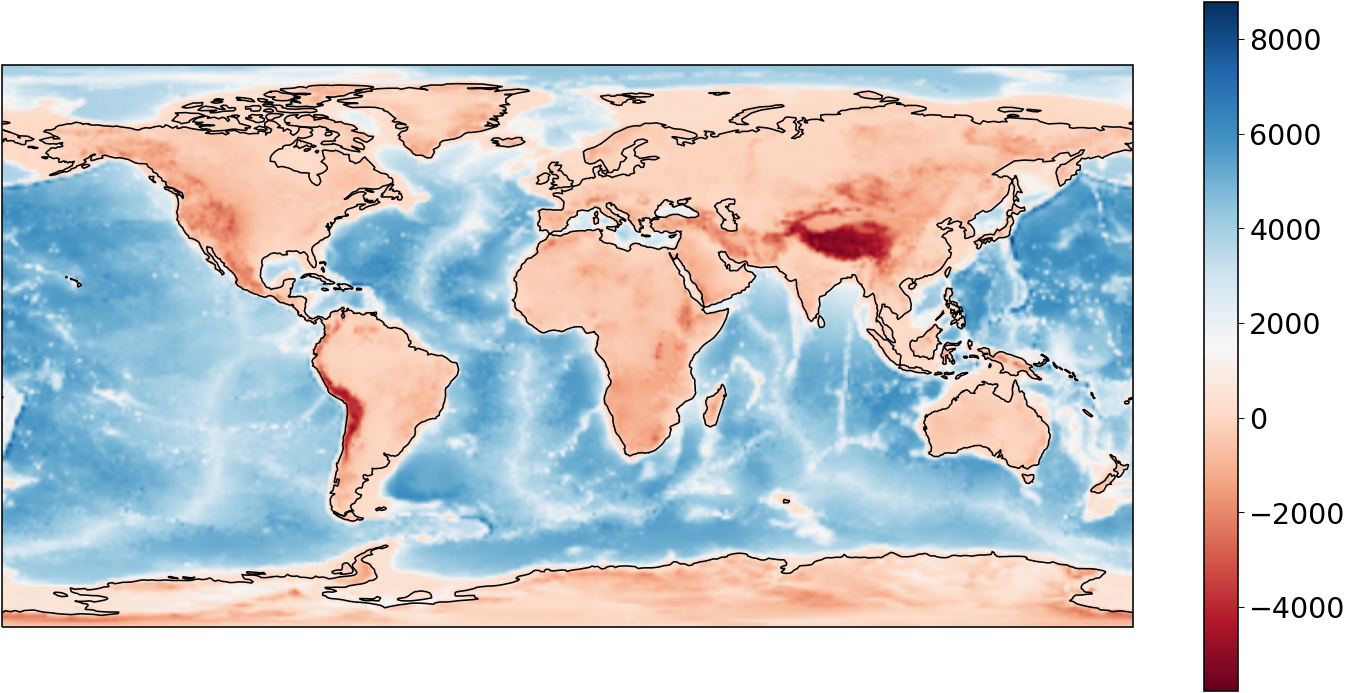

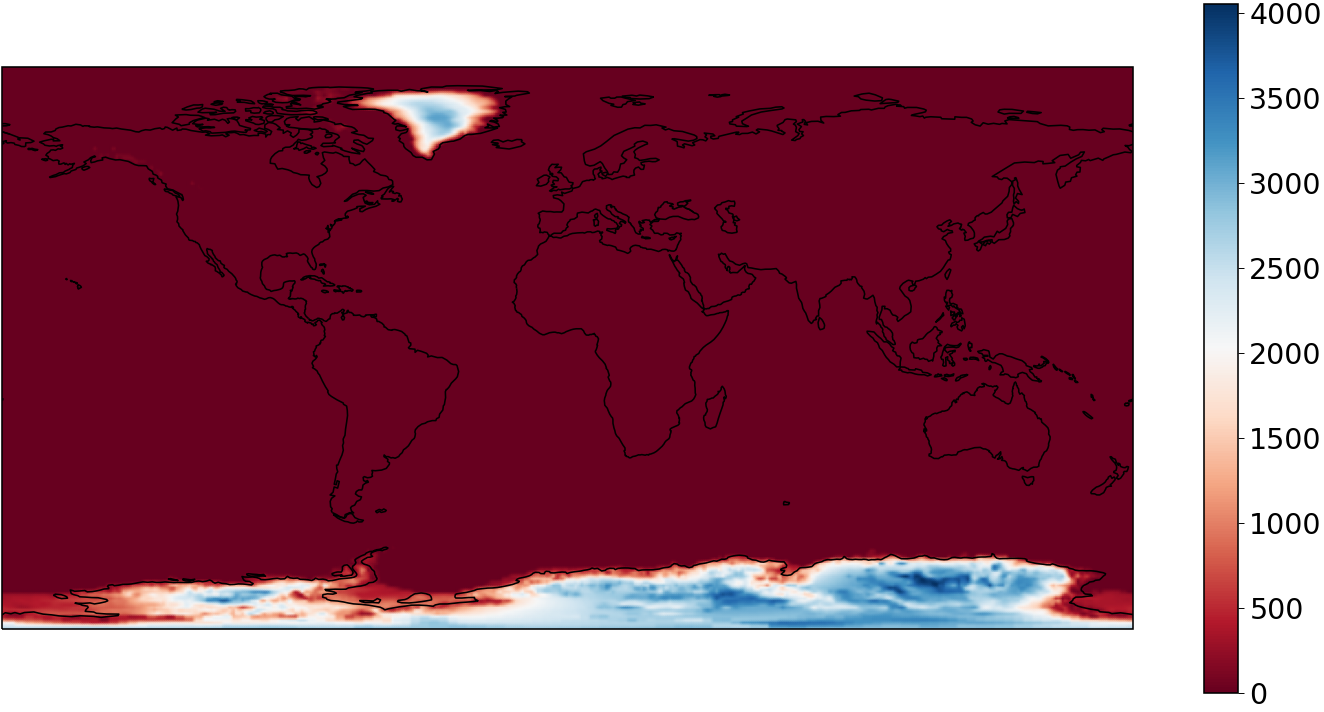

In [45]:
sl0,ice0 = SL.get_sl_ice_data(L)
SL.geo_plot(sl0,'RdBu')
SL.geo_plot(ice0,'RdBu')

From the sea level and ice, we can compute the ocean area. Note that the ocean function is defined to equal one where there is to equal one where water is present and zero elsewhere. Based on a simple isostatic balance between the water and ice, we have
\begin{equation}
C(\theta,\varphi) = \left\{
\begin{array}{cc}
1 & \rho_{w} SL(\theta,\varphi) \ge \rho_{i} I(\theta,\varphi) \\
0 & \rho_{w} SL(\theta,\varphi) < \rho_{i} I(\theta,\varphi) 
\end{array}
\right.
\end{equation}
The ocean area is then defined as
\begin{equation}
A = \int_{\partial M} C\, \mathrm{d} S.
\end{equation}


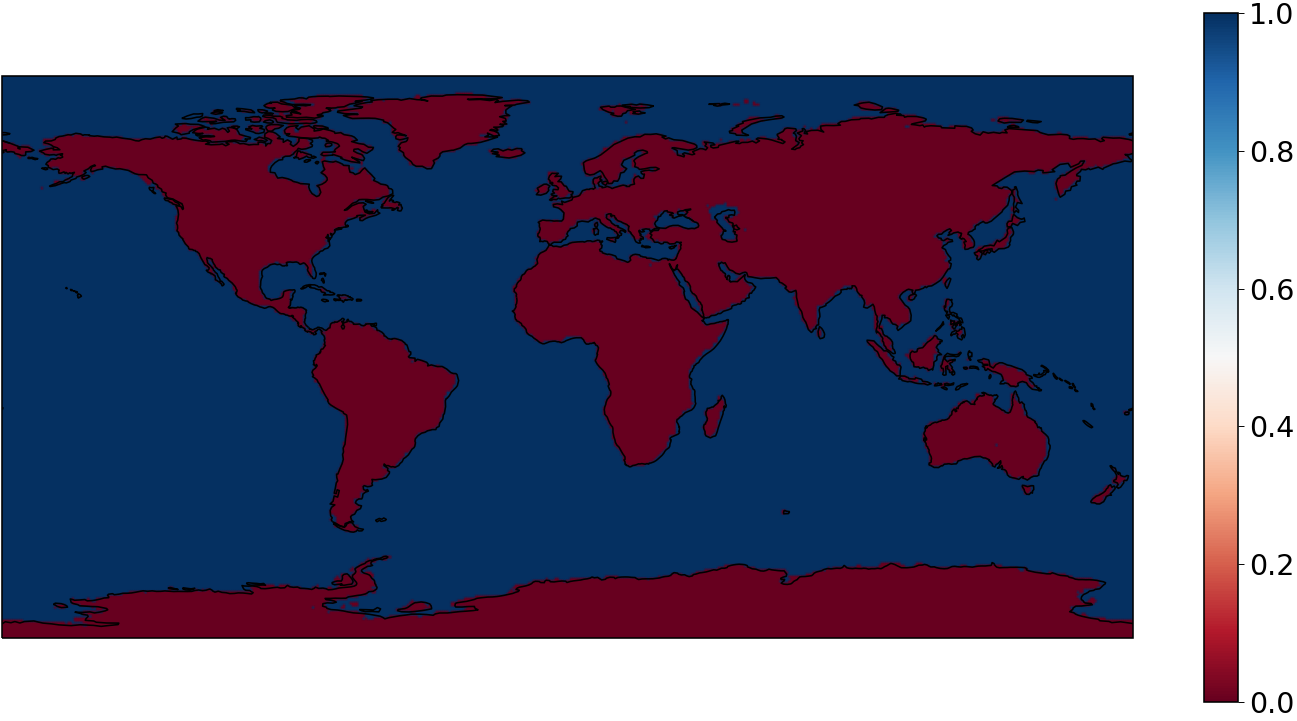

fraction of surface which is ocean =  0.7129602337196239


In [47]:
C = SL.ocean_function(sl0,ice0)
SL.geo_plot(C,'RdBu')
# compute the surface area of the Earth and print fraction that is oceans
A = SL.surface_integral(C)
A_earth = 4*pi*SL.b**2
print('fraction of surface which is ocean = ',A/A_earth)

We now set the ice to be melted, taking as an example a reduction in the height of the Greenland ice sheet by 1%. This can be done as follows:


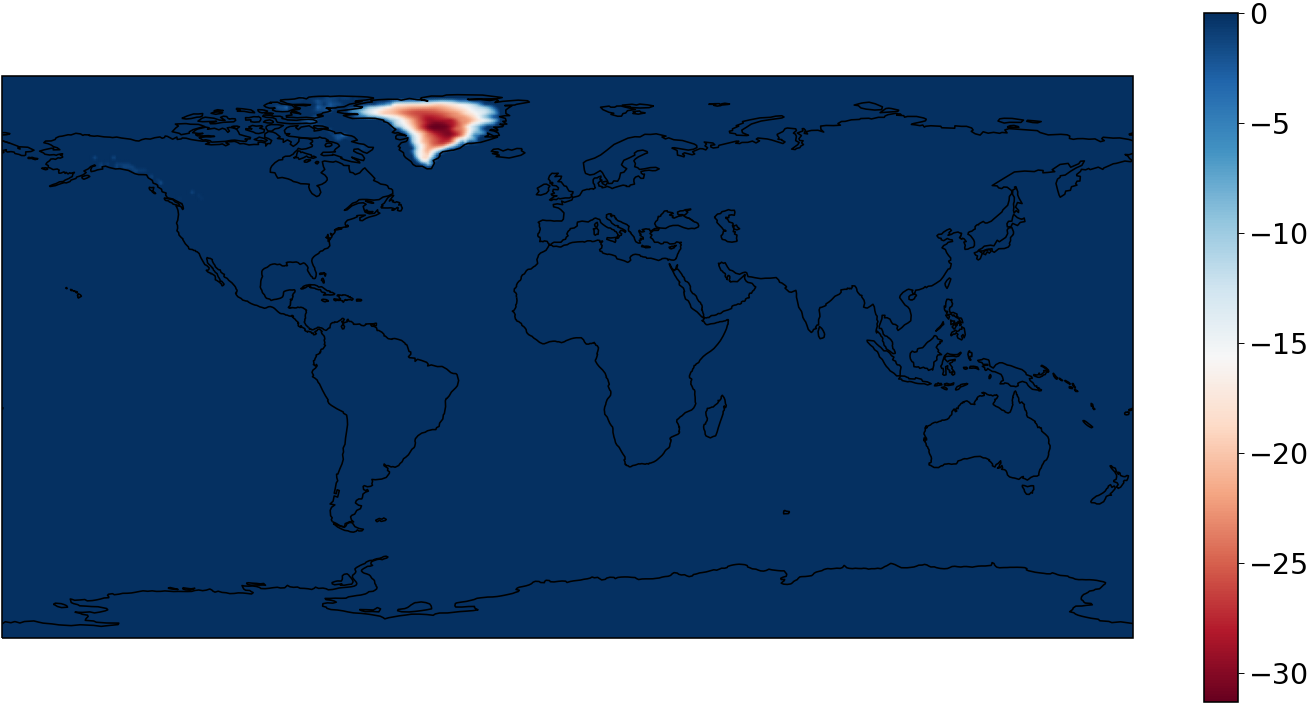

In [54]:
ice = -0.01*SL.zero_southern_hemisphere(ice0)
SL.geo_plot(ice,'RdBu')

Having now defined the problem to be solved, we can solve the sea level equation by calling the following function. Note that it returns perturbations to (at the chosen trunction degree) the sea level change, $SL$, the vertical displacement, $u$, the gravitational potential, $\phi$, and the centrifugal potential, $\psi$ (the latter two plotted as the equivalent change in sea level by scaling by $-1/g$).

iteration =  1 relative change =  18.152374179275043
iteration =  2 relative change =  0.3442238371830459
iteration =  3 relative change =  0.0394626517938161
iteration =  4 relative change =  0.006026597557569351
iteration =  5 relative change =  0.001047530517050403
iteration =  6 relative change =  0.00019559069706711469


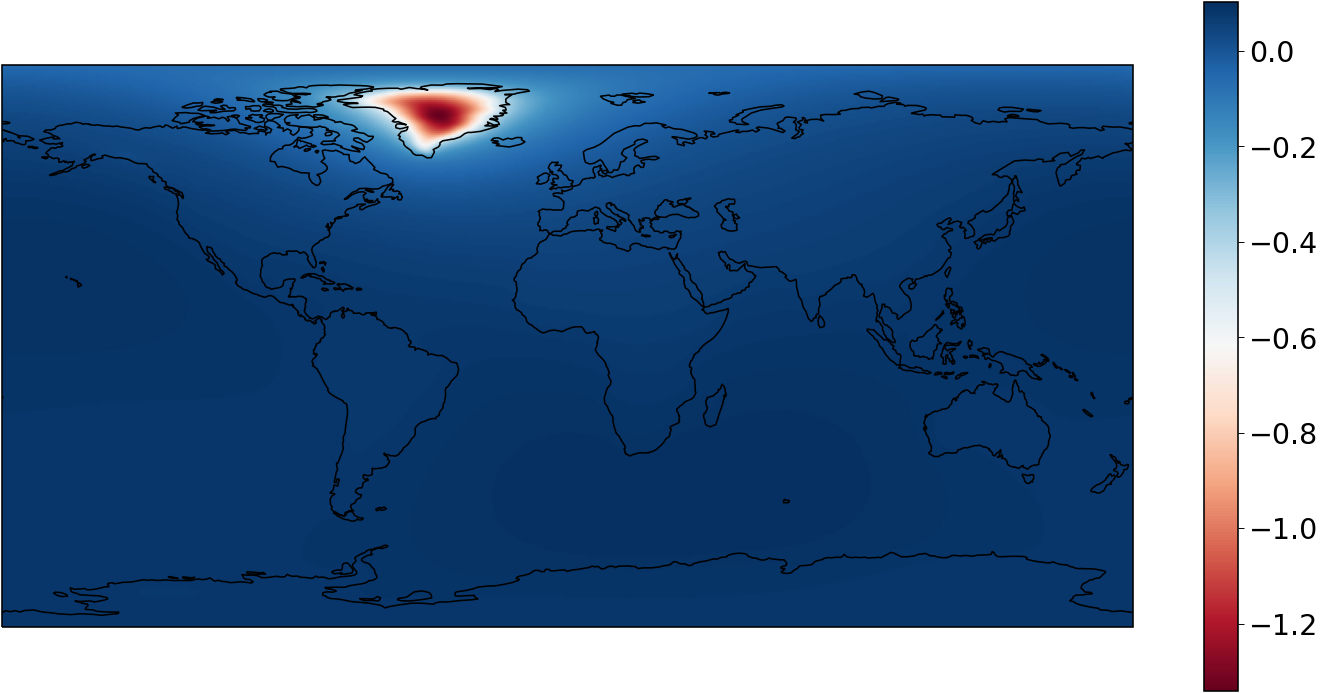

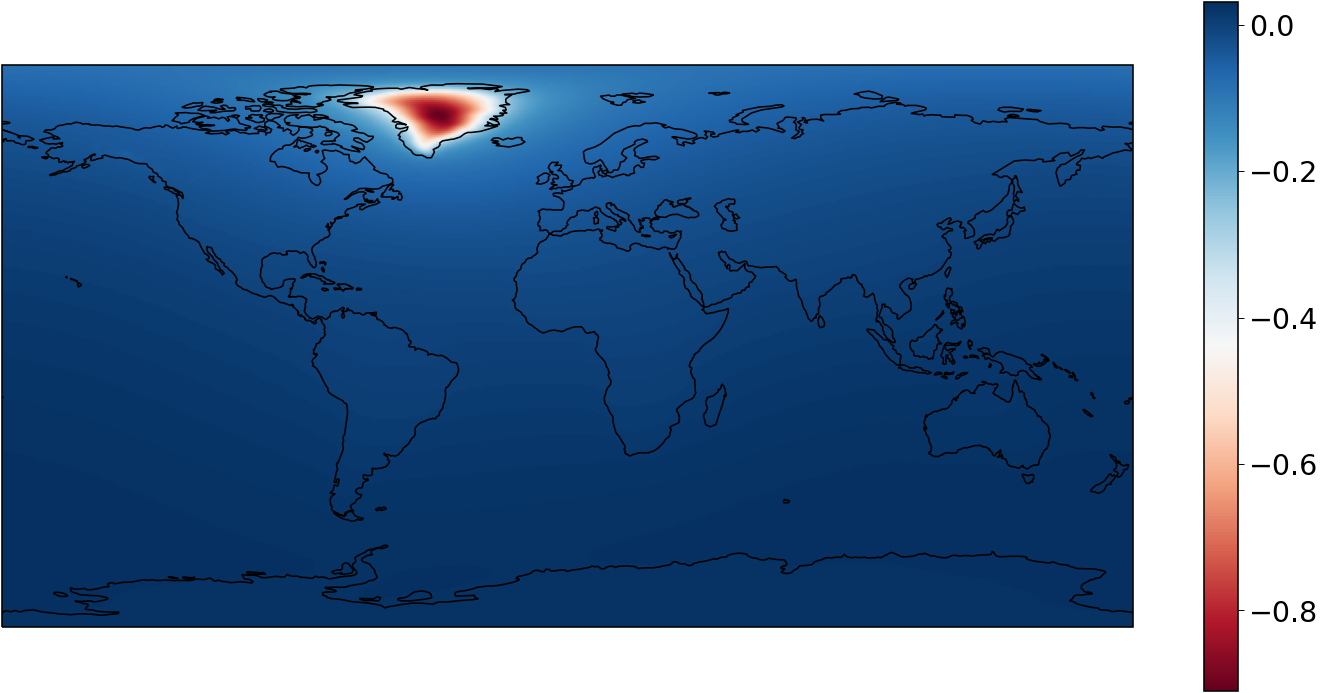

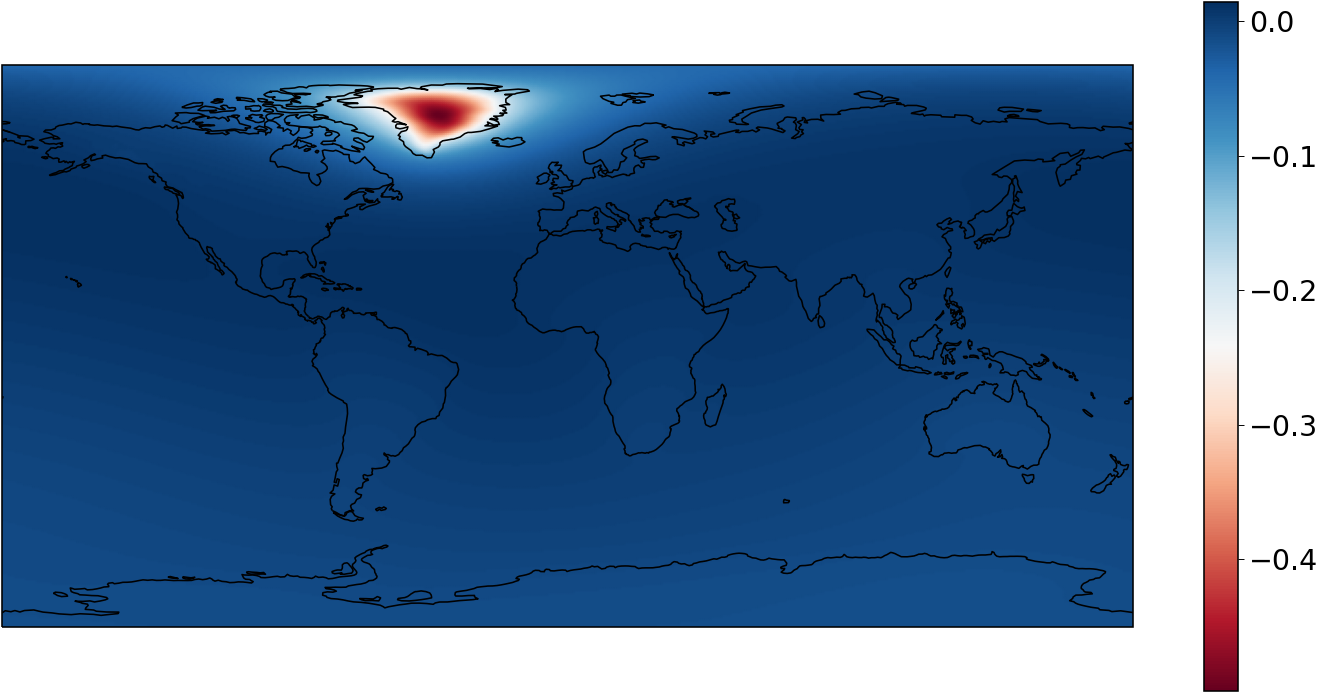

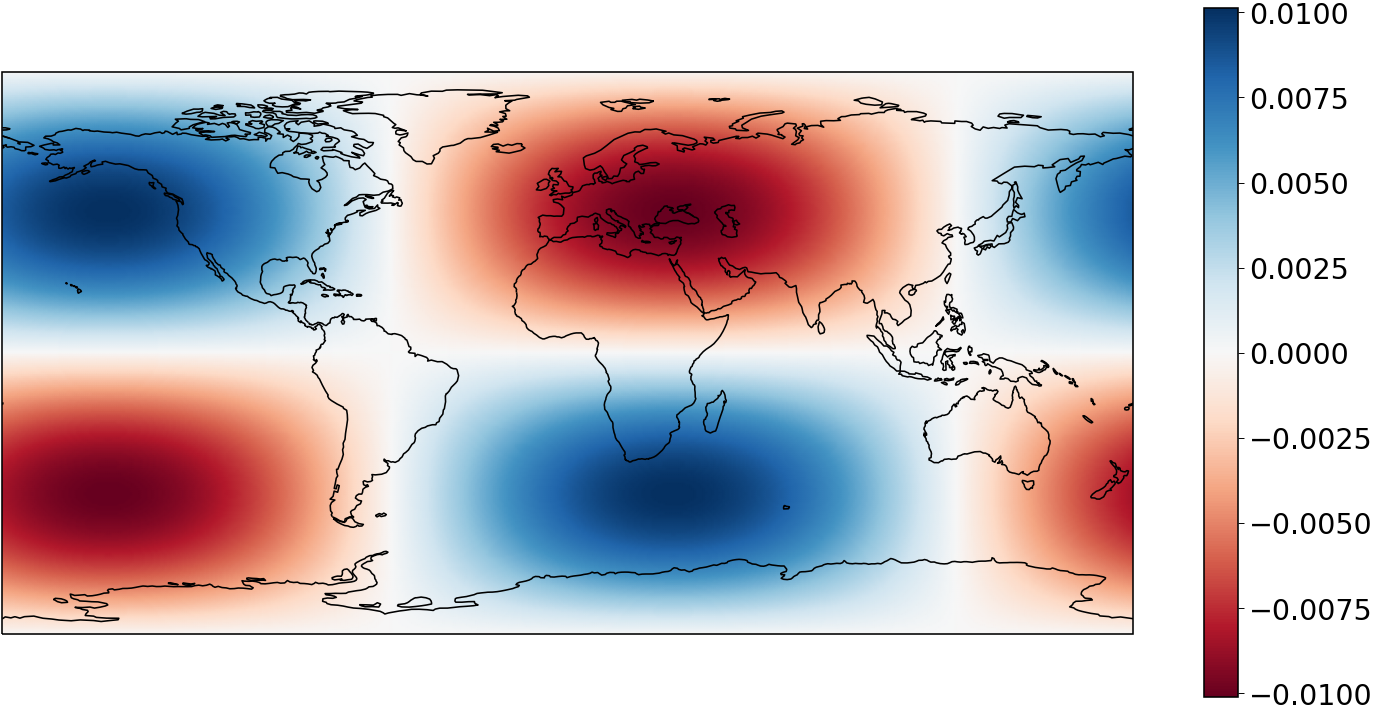

In [55]:
sl,u,phi,psi =  SL.fingerprint(C,ice)
SL.geo_plot(sl,'RdBu')
SL.geo_plot((-1)*u,'RdBu')
SL.geo_plot((-1./SL.g)*phi,'RdBu')
SL.geo_plot((-1./SL.g)*psi,'RdBu')

# Basic types of observation (present-day rate problem):

## Sea level rates

Data here are rates of sea level change at specific locations. This is the kind of information provided by tide gauges. A formula might then be:
\begin{equation}
d_{i} = \dot{SL}(\theta_{i},\varphi_{i})
\end{equation}

## Satellite altimetry rates

This measurement type produces rates of change of sea surface height over some region of the oceans. The region is usually a band of latitudes with $\pm 66$ being the norm. A key point here is that it is not sea level directly that is measured by changes in the position of the mean sea surface relative to the Earth's centre of mass. 
\begin{equation}
\dot{SSH} = \dot{SL} + \dot{u} + \frac{\dot{\psi}}{g}, 
\end{equation}
where $u$ is the vertical displacement.

# Vertical displacement measurements

These could be obtained using GPS, and would be provided at some discrete range of points.
\begin{equation}
d_{i} = u(\theta_{i},\varphi_{i})
\end{equation}

# Gravitational field measurements

Here the quantity measured in $\phi$, these are ususally expressed as spherical harmonic coefficients, and are returned for degrees in the range $2 \le l \le L$ for some $L$. A typical value might be 64. 
 

In [69]:
class tide_gauge_data:
    def __init__(self,nloc):
        self.nloc  = nloc
        self.lats  = np.zeros(nloc)
        self.lons  = np.zeros(nloc)
        self.rates = np.zeros(nloc)
 

    

In [71]:
data = tide_gauge_data(10)
data.print_values()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


NameError: name 'print_values' is not defined